# From Statistical Physics to Data-Driven Modelling
     with Applications to Quantitative Biology
Tutorial 2: Entropy and information in neural spike trains. 

This tutorial is based on the works: 

-R. R. de Ruyter van Steveninck, G. D. Lewen, S. P. Strong, R. Koberle, W. Bialek Reproducibility and Variability in Neural Spike Trains, Science 275, 1805-1808 (1997)

-K. Koch, J. McLean, M. Berry, P. Sterling, V. Balasubramanian, M. A. Efficiency of Information Transmission by Retinal Ganglion Cells Current Biology, 14, 15231530, (2004).


Solution Notebook SC, RM, FZ

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import numpy.matlib
#matplotlib inline
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["mathtext.fontset"] = "dejavuserif"
#plt.rcParams["figure.figsize"] = (10, 8)
#plt.rcParams["font.size"] = 26

Import data

In [3]:

data=np.loadtxt('../Data/dati2-berry.dat')

#parameters
#time bin =10 ms
dt=0.01
#length (in seconds) of a word
ls=0.1
#length (in bits) of a word
l=int(ls/dt)
#length (in seconds) of a repetition
T=26.5
#number of bins for each repetition of duration 26.5 s
M=int(T/dt)
#number of repetition of the input
Nr=120
#number of repetitions used in the data analysis
#verify for Nrp=1, the noise entropy should be zero
Nrp=120
#Number of words
Nwt=np.power(2,l)


#Find lines in the data delimiting neurons spike trains + add last line
Ndata=np.size(data);
Ncells=40;
tc=(np.zeros(Ncells+1)).astype(int)
tc[0:Ncells]=np.where(data == 4000)[0][:]
tc[Ncells]=Ndata

Question 0: Raster Plot

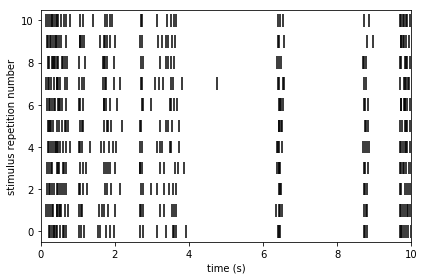

In [4]:

data0=data[tc[0]+2:tc[1]]
x=data0%T
y=data0//T
plt.xlim([0,10])
plt.ylim([-0.5,10.5])
plt.vlines(x,y-0.3,y+0.3)
plt.xlabel('time (s)')
plt.ylabel('stimulus repetition number')
#plt.title('Raster plot for cell 1 (only 10 repetitions and 10 sec are shown)')
plt.tight_layout()
#plt.savefig('raster_dt001cell1.pdf')
plt.show()


In [5]:
#Function that converts the spikes for a single neuron into a matrix
#The matrix contains the number of spikes in a bin of size dt for each repetition (line)
def data_to_table (i):
    datai=data[tc[i]+2:tc[i+1]]
    # build the spiking matrix for the neuron i, using sparse matrix
    tt=datai%T
    #time bin of the spike (0:M-1)
    y=np.floor(tt/dt)
    #interval number (0:119)
    x=np.floor(datai//T)
    # conversion to a sparse matrix 
    z=np.ones(np.size(datai))
    s=coo_matrix((z,(x,y)),dtype=np.int8,shape=(Nr,M))
    sreal=s.toarray()
    return sreal

#Function that performs the conversion from a string of bits to an integer
#note that some elements of word can be >1; the first line makes the conversion to 0,1
def toint (word):
    y=(word[:]>0).astype(int)
    bw=[str(t) for t in y]
    bw2=''.join(bw)
    return int(bw2,2)  



In [6]:
#Poisson entropy
def Sp (f, dt):
    return (f*dt*np.exp(-f*dt)-(1-np.exp(-f*dt))*np.log(1-np.exp(-f*dt)))/np.log(2)



Question 1: Entropy as a function of dt of a Poisson process of frequency f=4 Hz


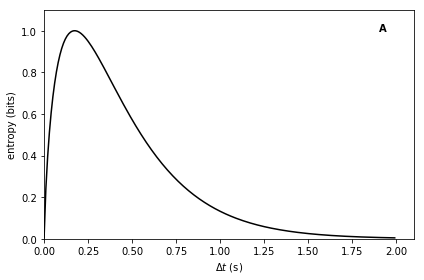

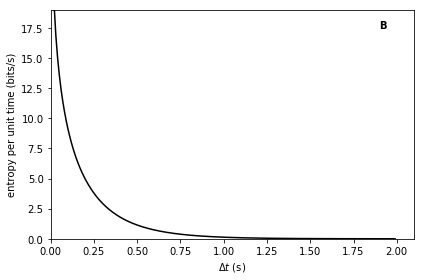

In [7]:
f=4
Deltat = np.arange(0.0001,2,0.01)
fe=Sp(f,Deltat)
fet=Sp(f,Deltat)/Deltat
plt.plot(Deltat,fe,color='black')
plt.xlim([0,2.1])
plt.ylim([0,1.1])
plt.xlabel('$\Delta t$ (s)')
plt.ylabel('entropy (bits)')
#plt.title('Entropy vs $\Delta t$')
plt.text(1.9, 1, 'A', fontweight='bold')
plt.tight_layout()
plt.savefig('entropypvsdt_final.pdf')
plt.show()
plt.xlim([0,2.1])
plt.ylim([0,19])
plt.plot(Deltat,fet,color='black')
plt.xlabel('$\Delta t$ (s)')
plt.ylabel('entropy per unit time (bits/s)')
#plt.title('Entropy per unit time vs $\Delta t$')
plt.text(1.9, 17.5, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('entropypertimevsdt_final.pdf')
plt.show()

Question 2: Calculation of the total entropy Stotal,the noise entropy Snoise, the information about the stimuli I and frequency for each neuron. Plot of Snoise, Stotal and I for the 40 neurons.

In [8]:
#Inizialisation of entropies
stot=np.zeros(Ncells)
snoise=np.zeros(Ncells)
info=np.zeros(Ncells)
freq=np.zeros(Ncells)
snoiset=np.zeros((Ncells,M-l))

#Calculation of entropies for each neuron
for i in range(Ncells):
    #average frequency of the cell
    freq[i]=(tc[i+1]-tc[i]-2)/(T*Nr)
    #conversion of the spike train to a matrix
    smatrix = data_to_table(i)
    #calculation of frequencies P(W,t) for the Nwt=1024 words
    fwt=np.zeros((Nwt,M-l))
    for r in range (Nrp):                          
        ki=0
        for tbin in range(M-l):
            word=smatrix[r,ki:ki+l] 
            Nw=toint(word)                  
            fwt[Nw,tbin]+=1
            ki+=1
    fwt=fwt/Nrp
    #averages frequencies P(W) of the words over all times
    fav=np.sum(fwt,axis=1)/(M-l)
    #single cell total entropy \sum_W P(W) \log P(W), with small regularization to avoid infinity
    ln=np.log(fav+0.0000001)/np.log(2)
    stot[i]=-np.sum(fav*ln)
    #entropies S(t) at fixed time bin
    lnt=np.log(fwt+0.0000001)/np.log(2)
    sbin=-np.sum(fwt*lnt,axis=0)
    snoiset[i,:]=sbin
    #averages of S(t) over the time bin to get Snoise
    snoise[i]=np.sum(sbin)/(M-l)
    #information I = Stotal - Snoise
    info[i]=stot[i]-snoise[i]                


Plot of Snoise, Stotal and I for the 40 neurons

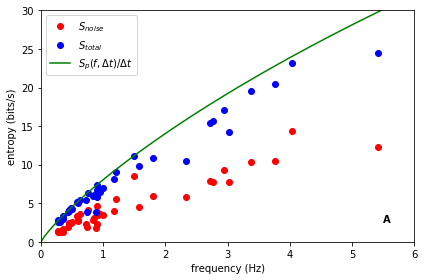

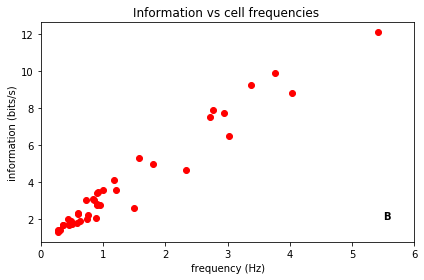

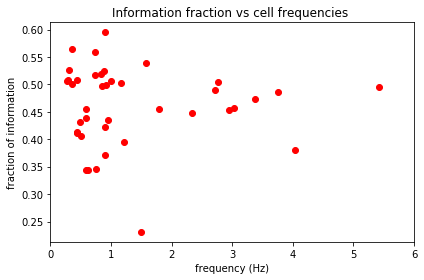

In [9]:

fe0=np.arange(0.00001,6,0.06)
fe1=Sp(fe0,dt)/dt
fig, ax=plt.subplots()
ax.plot(freq[:],snoise[:]/ls,'ro',label='$S_{noise}$')
ax.plot(freq[:],stot[:]/ls,'bo',label='$S_{total}$')
ax.plot(fe0,fe1,'g',label='$S_p(f,\Delta t)/\Delta t$')
legend = ax.legend(loc='upper left')
plt.ylim([0,30])
plt.xlim([0,6])
plt.xlabel('frequency (Hz)')
plt.ylabel('entropy (bits/s)')
#plt.title('Noise Entropies vs cell frequencies ')
plt.text(5.5, 2.5, 'A', fontweight='bold')
plt.tight_layout()
plt.savefig('svsfreqdt001ls01_final.pdf')
plt.show()
plt.plot(freq[:],info[:]/ls,'ro')
plt.xlim([0,6])
plt.xlabel('frequency (Hz)')
plt.ylabel('information (bits/s)')
plt.text(5.5, 2, 'B', fontweight='bold')
plt.title('Information vs cell frequencies ')
plt.tight_layout()
#plt.savefig('infovsfreqdt001ls01_final.pdf')
plt.show()
plt.plot(freq[:],info[:]/stot[:],'ro')
plt.xlim([0,6])
plt.xlabel('frequency (Hz)')
plt.ylabel('fraction of information')
plt.title('Information fraction vs cell frequencies ')
plt.tight_layout()
#plt.savefig('ratiovsfreqdt001ls01_final.pdf')
plt.show()

Question 3: Compute I as a function of the number of repetitions of the stimulus and of the duration of the word for the first neuron.

In [10]:


#this function computes I for general parameters (similar to the one above)
def computeI (myM,myl,myNr,myneuron):
    #conversion of the spike train to a matrix
    smatrix = data_to_table(myneuron)
    myNwt=np.power(2,myl)
    fwt=np.zeros((myNwt,myM-myl))
    for r in range (myNr):
        #calculation of frequencies for the 1024 words for each neuron                  
        ki=0
        for tbin in range(myM-myl):
            word=smatrix[r,ki:ki+myl] 
            Nw=toint(word)                  
            fwt[Nw,tbin]+=1
            ki+=1
    # averages frequencies of the words
    fwt=fwt/myNr
    fav=np.sum(fwt,axis=1)/(myM-myl)
    #single cell total entropy
    #small regularization to avoid infinity
    ln=np.log(fav+0.0000001)/np.log(2)
    Zstot=-np.sum(fav*ln)
    #entropies at fixed time bin
    lnt=np.log(fwt+0.0000001)/np.log(2)
    sbin=-np.sum(fwt*lnt,axis=0)
    #averages of entropies at fixed time bin
    Zsnoise=np.sum(sbin)/(myM-myl)
    return Zstot-Zsnoise

In [11]:
#compute I as a function of the number of repetitions
neur=0
I=[]
for k in range(10,Nr+1,10):
    app = computeI(M,l,k,neur)
    I.append([k,app])     
I=np.array(I)

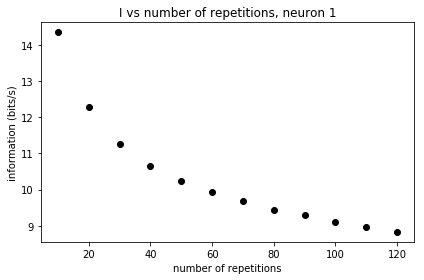

In [12]:
#plot I as a function of the number of repetitions
plt.plot(I[:,0],I[:,1]/ls,'ko')      
plt.xlabel('number of repetitions')
plt.ylabel('information (bits/s)')
#plt.text(115, 14, 'A', fontweight='bold')
plt.title('I vs number of repetitions, neuron 1')
plt.tight_layout()
#plt.savefig('limit_I_vs_rep.pdf')
plt.show()

In [13]:
#compute I as a function of l
I=[]
for k in range(2,11):
    app = computeI(M,k,Nr,neur)/(dt*k)
    I.append([k*dt,app])     
I=np.array(I)

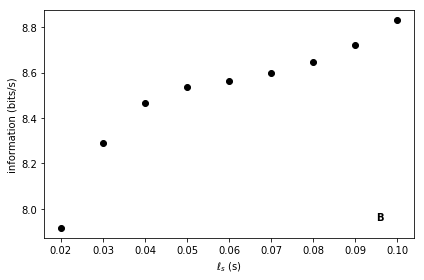

In [14]:
#plot I as a function of the duration of the word l
plt.plot(I[:,0],I[:,1],'ko')      
plt.xlabel('$\ell_s$ (s)')
plt.ylabel('information (bits/s)')
#plt.title('I vs duration of the word, neuron 1')
plt.text(0.095, 7.95, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('limit_I_vs_T.pdf')
plt.show()

Question 4 (Bonus): Plot the entropy as a function of the time (bin number) and compare with the frequency.  

2.319421465688266 1.4363140790727604 4.032704402515724


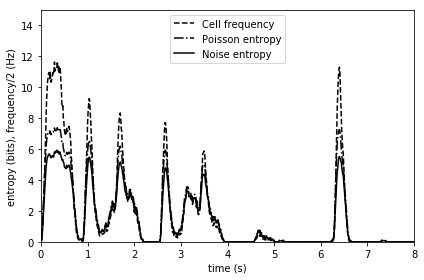

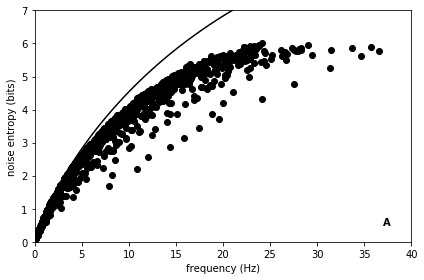

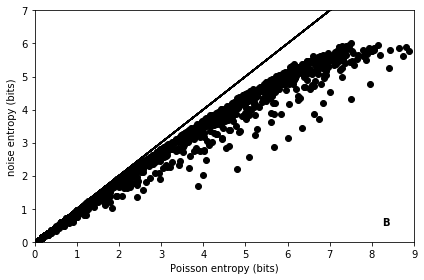

In [15]:

#Select the data for one neuron
neur=0
datan=data[tc[neur]+2:tc[neur+1]]
Ndatan=np.size(datan)
#compute the time-dependent frequency averaged over bins
freqt=np.zeros(M)
for t in range(Ndatan):
    tt=datan[t]%T
    y=int(np.floor(tt/dt))
    freqt[y]+=1
freqt/=(Nr*dt)
#average the time-dependent frequency over l bins and compute the Poisson entropy
freqtbin=np.zeros(M-l)
snoiseP=np.zeros(M-l)
for t in range(M-l):
    for k in range(l):
        freqtbin[t]+=freqt[t+k]
    freqtbin[t]/=l
    snoiseP[t]=Sp(freqtbin[t]+0.00000001,dt)*l    
#compute the Poisson entropy for comparison
fe=np.zeros((100,2))
f=0.00001
for k in range(0,100):
    fe[k,0]=f
    fe[k,1]=Sp(f,dt)*l
    f=f+0.5
#output the figures
print(stot[neur],snoise[neur],freq[neur])
time=np.array(range(np.size(freqtbin)))
time=time*dt
#time dependent plot
fig, ax=plt.subplots()
ax.plot(time[:],freqtbin[:]/2,'k--',label='Cell frequency')
ax.plot(time[:],snoiseP[:],'k-.',label='Poisson entropy')
ax.plot(time[:],snoiset[neur,:],'k-',label='Noise entropy')
legend = ax.legend(loc='upper center')
plt.xlim([0,8])
plt.ylim([0,15])
plt.xlabel('time (s)')
plt.ylabel('entropy (bits), frequency/2 (Hz)')
#plt.title('Noise Entropy and cell frequency vs time, neuron 1')
plt.tight_layout()
plt.savefig('time_dep.pdf')
plt.show()
#parametric plot, frequency
plt.plot(freqtbin[:],snoiset[neur,:],'ko',fe[:,0],fe[:,1],'k')
plt.xlim([0,40])
plt.ylim([0,7])
plt.xlabel('frequency (Hz)')
plt.ylabel('noise entropy (bits)')
#plt.title('Noise Entropy vs cell frequency (parametric in time), neuron 1')
plt.text(37, 0.5, 'A', fontweight='bold')
plt.tight_layout()
plt.savefig('time_freq_vs_Snoise.pdf')
plt.show()
#parametric plot, entropy
plt.plot(snoiseP[:],snoiset[neur,:],'ko',snoiseP[:],snoiseP[:],'k')
plt.xlim([0,9])
plt.ylim([0,7])
plt.xlabel('Poisson entropy (bits)')
plt.ylabel('noise entropy (bits)')
#plt.title('Noise Entropy vs Poisson Entropy (parametric in time), neuron 1')
plt.text(8.25, 0.5, 'B', fontweight='bold')
plt.tight_layout()
#plt.savefig('time_Spoisson_vs_Snoise.pdf')
plt.show()